In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import datasets, transforms, models
from torchvision.models import ResNet18_Weights
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

In [46]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [47]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [48]:
# Load Pretrained Weights & Transforms
weights = models.ResNet50_Weights.DEFAULT
pretrained_transforms = weights.transforms()  # built-in preprocessing transforms

# Augmentation + Preprocessing for Training
train_transform = transforms.Compose([
    transforms.Resize(224),                     # ensure size is correct
    transforms.RandomHorizontalFlip(p=0.5),     # augmentation
    transforms.RandomRotation(15),              # augmentation
    transforms.ColorJitter(0.2, 0.2, 0.2),      # augmentation
    pretrained_transforms           # built-in normalization
])

# Preprocessing for Testing (No Augmentation)
test_transform = pretrained_transforms  # directly use built-in transforms

In [49]:
# Download full dataset first
full_train = datasets.CIFAR10(root='./data', train=True,
                              download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False,
                               download=True, transform=test_transform)

# Create a SMALL subset - only 1000 images for training!
# This simulates real-world scenarios where you don't have much data
small_train_size = 1000
indices = torch.randperm(len(full_train))[:small_train_size]
small_train_dataset = Subset(full_train, indices)

print(f"Training with only {len(small_train_dataset)} images")
print(f"Testing with {len(test_dataset)} images")

Training with only 1000 images
Testing with 10000 images


In [50]:
# Create data loaders
train_loader = DataLoader(small_train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [51]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Create the model
simple_cnn = SimpleCNN(num_classes=10).to(device)
print("Simple CNN Architecture:")
print(simple_cnn)
print(f"\nTotal parameters: {sum(p.numel() for p in simple_cnn.parameters()):,}")

Simple CNN Architecture:
SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)

Total parameters: 25,786,186


In [52]:
# Load pre-trained ResNet-18 with official weights
weights = ResNet18_Weights.DEFAULT
pretrained_model = models.resnet18(weights=weights)

In [53]:
# Freeze ALL layers - we're doing feature extraction
for param in pretrained_model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_features, 10)

pretrained_model = pretrained_model.to(device)

print("Transfer Learning Model (Feature Extraction Phase):")
print(f"Pre-trained on ImageNet with {weights.meta['num_params']:,} parameters")
print(f"Frozen layers: All except final FC layer")
print(f"Trainable parameters: {sum(p.numel() for p in pretrained_model.parameters() if p.requires_grad):,}")

Transfer Learning Model (Feature Extraction Phase):
Pre-trained on ImageNet with 11,689,512 parameters
Frozen layers: All except final FC layer
Trainable parameters: 5,130


In [54]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, model_name):
    print(f"\n{'='*50}")
    print(f"Training {model_name}")
    print(f"{'='*50}")

    history = {'train_loss': [], 'time_per_epoch': []}
    model.train()

    for epoch in range(num_epochs):
        start_time = time.time()
        running_loss = 0.0
        correct = 0
        total = 0

        # Progress bar for each epoch
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            pbar.set_postfix({'loss': loss.item(),
                            'acc': 100 * correct / total})

        # Epoch statistics
        epoch_loss = running_loss / len(train_loader)
        epoch_time = time.time() - start_time

        history['train_loss'].append(epoch_loss)
        history['time_per_epoch'].append(epoch_time)

        print(f'Epoch {epoch+1}: Loss={epoch_loss:.4f}')

    return history

In [55]:
def evaluate_model(model, test_loader, model_name):
    """Evaluate model on test set"""
    print(f"\nEvaluating {model_name}...")
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'{model_name} Test Accuracy: {accuracy:.2f}%')
    return accuracy

In [56]:
# Setup for Simple CNN
criterion = nn.CrossEntropyLoss()
optimizer_simple = optim.Adam(simple_cnn.parameters(), lr=0.001)

# Train for 5 epochs (limited training!)
simple_history = train_model(
    model=simple_cnn,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer_simple,
    num_epochs=5,
    model_name="Simple CNN (From Scratch)"
)

# Evaluate
simple_test_acc = evaluate_model(simple_cnn, test_loader, "Simple CNN")


Training Simple CNN (From Scratch)


Epoch 1/5: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s, loss=2.3, acc=9.5]  


Epoch 1: Loss=2.5377


Epoch 2/5: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s, loss=2.19, acc=17.3]


Epoch 2: Loss=2.2550


Epoch 3/5: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s, loss=1.96, acc=24.1]


Epoch 3: Loss=2.0773


Epoch 4/5: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s, loss=1.71, acc=29]  


Epoch 4: Loss=1.9215


Epoch 5/5: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s, loss=2.42, acc=31.6]


Epoch 5: Loss=1.9059

Evaluating Simple CNN...


Testing: 100%|██████████| 313/313 [00:19<00:00, 16.47it/s]

Simple CNN Test Accuracy: 33.63%


In [57]:
# Setup for Transfer Learning
# Phase 1: Feature Extraction
criterion = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(pretrained_model.fc.parameters(), lr=0.001)

# Train for only 3 epochs in Phase 1
transfer_history_phase1 = train_model(
    model=pretrained_model,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer_transfer,
    num_epochs=3,
    model_name="Transfer Learning - Phase 1 (Feature Extraction)"
)

# Evaluate after Phase 1
transfer_test_acc_phase1 = evaluate_model(pretrained_model, test_loader,
                                          "Transfer Learning (Phase 1)")


Training Transfer Learning - Phase 1 (Feature Extraction)


Epoch 1/3: 100%|██████████| 32/32 [00:04<00:00,  6.60it/s, loss=2.13, acc=23.1]


Epoch 1: Loss=2.1669


Epoch 2/3: 100%|██████████| 32/32 [00:04<00:00,  6.55it/s, loss=1.69, acc=45.8]


Epoch 2: Loss=1.7074


Epoch 3/3: 100%|██████████| 32/32 [00:04<00:00,  6.63it/s, loss=1.38, acc=57]  


Epoch 3: Loss=1.4289

Evaluating Transfer Learning (Phase 1)...


Testing: 100%|██████████| 313/313 [00:20<00:00, 15.25it/s]

Transfer Learning (Phase 1) Test Accuracy: 58.13%


In [58]:
print("Phase 2: Fine-Tuning (Unfreezing deeper layers)")

# Unfreeze the last residual block (layer4) for fine-tuning
for param in pretrained_model.layer4.parameters():
    param.requires_grad = True

# Also keep the classifier trainable
for param in pretrained_model.fc.parameters():
    param.requires_grad = True

print(f"Trainable parameters now: {sum(p.numel() for p in pretrained_model.parameters() if p.requires_grad):,}")

Phase 2: Fine-Tuning (Unfreezing deeper layers)
Trainable parameters now: 8,398,858


In [59]:
# Use a smaller learning rate for fine-tuning!
optimizer_finetune = optim.Adam(
    filter(lambda p: p.requires_grad, pretrained_model.parameters()),
    lr=0.0001  
)

In [60]:
# Train for 2 more epochs
transfer_history_phase2 = train_model(
    model=pretrained_model,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer_finetune,
    num_epochs=2,
    model_name="Transfer Learning - Phase 2 (Fine-Tuning)"
)

# Final evaluation
transfer_test_acc_final = evaluate_model(pretrained_model, test_loader,
                                        "Transfer Learning (Final)")


Training Transfer Learning - Phase 2 (Fine-Tuning)


Epoch 1/2: 100%|██████████| 32/32 [00:05<00:00,  6.33it/s, loss=1.46, acc=69.7] 


Epoch 1: Loss=1.0142


Epoch 2/2: 100%|██████████| 32/32 [00:05<00:00,  6.38it/s, loss=1.2, acc=82.3]  


Epoch 2: Loss=0.6146

Evaluating Transfer Learning (Final)...


Testing: 100%|██████████| 313/313 [00:20<00:00, 15.22it/s]

Transfer Learning (Final) Test Accuracy: 79.07%


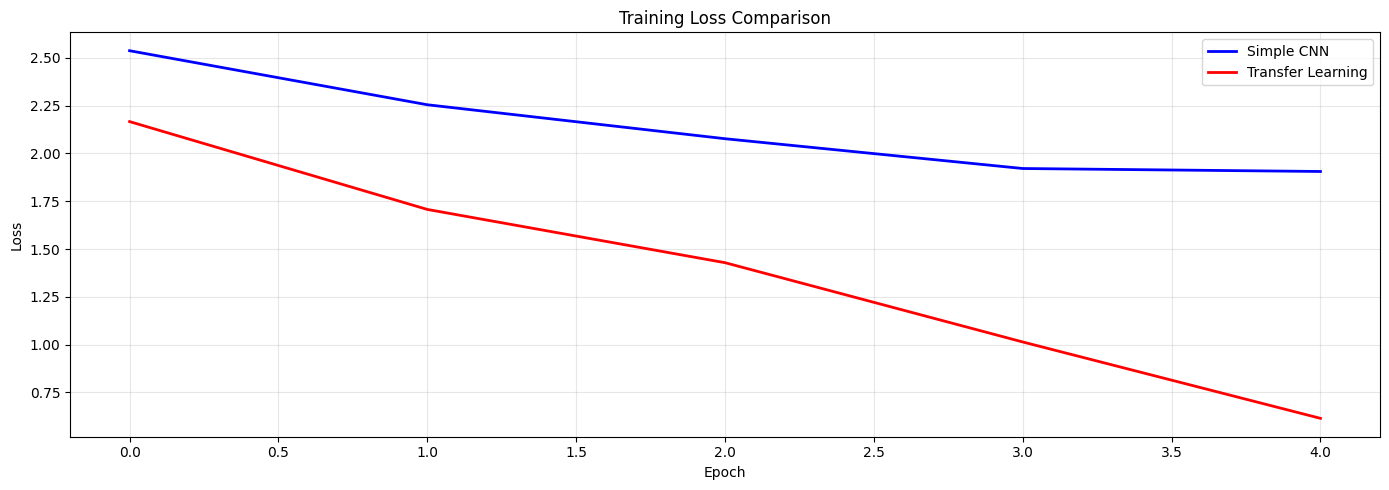

In [61]:
# Combine histories
transfer_history = {
    'train_loss': transfer_history_phase1['train_loss'] + transfer_history_phase2['train_loss'],
    'time_per_epoch': transfer_history_phase1['time_per_epoch'] + transfer_history_phase2['time_per_epoch']
}

# Create a figure with subplots
fig, ax = plt.subplots(1, 1, figsize=(14, 5))

# Plot training loss comparison
ax.plot(simple_history['train_loss'], 'b-', label='Simple CNN', linewidth=2)
ax.plot(transfer_history['train_loss'], 'r-', label='Transfer Learning', linewidth=2)

# Labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

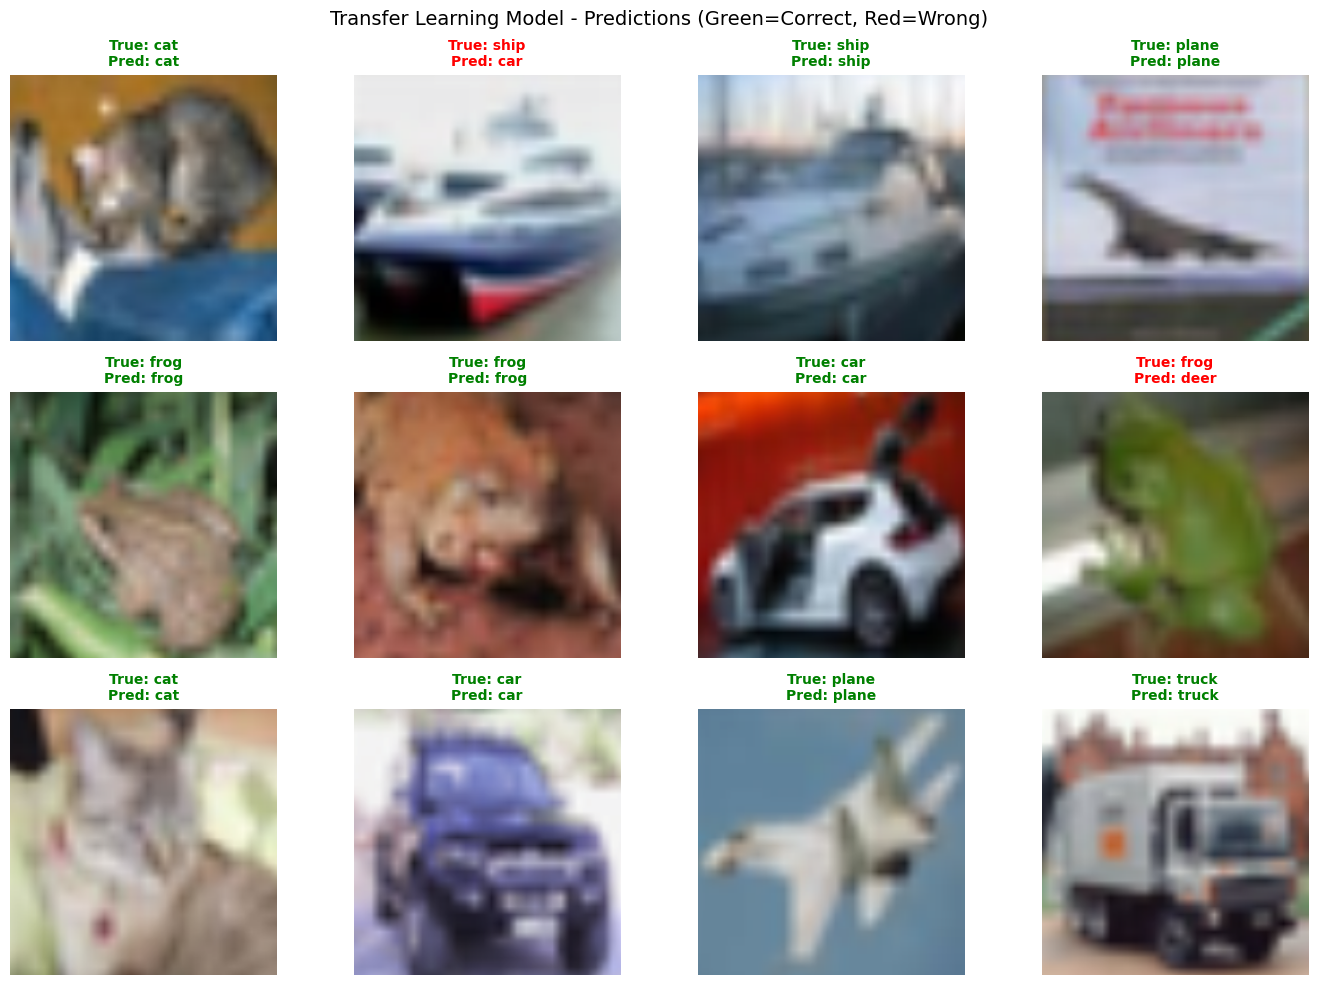

In [62]:
def visualize_predictions(model, test_loader, classes, num_images=12, model_name="Model"):
    model.eval()

    # Get a batch of test data
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Move back to CPU for visualization
    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()

    # Plot
    fig, axes = plt.subplots(3, 4, figsize=(14, 10))
    for idx, ax in enumerate(axes.flat):
        if idx < num_images:
            # Denormalize image
            img = images[idx].numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)

            ax.imshow(img)

            # green if correct, red if wrong
            true_label = classes[labels[idx]]
            pred_label = classes[predicted[idx]]
            color = 'green' if labels[idx] == predicted[idx] else 'red'

            ax.set_title(f'True: {true_label}\nPred: {pred_label}',
                        color=color, fontsize=10, weight='bold')
            ax.axis('off')

    plt.suptitle(f'{model_name} - Predictions (Green=Correct, Red=Wrong)',
                fontsize=14, y=0.98)
    plt.tight_layout()
    plt.show()


visualize_predictions(pretrained_model, test_loader, classes,
                     model_name="Transfer Learning Model")

In [63]:
# Create comparison dataframe
import pandas as pd

comparison_data = {
    'Metric': [
        'Training Data',
        'Training Epochs',
        'Total Training Time',
        'Test Accuracy',
        'Parameters Trained',
        'Strategy'
    ],
    'Simple CNN': [
        '1,000 images',
        '10',
        f"{sum(simple_history['time_per_epoch']):.1f}s",
        f"{simple_test_acc:.2f}%",
        f"{sum(p.numel() for p in simple_cnn.parameters()):,}",
        'From Scratch'
    ],
    'Transfer Learning': [
        '1,000 images',
        '10 (5+5)',
        f"{sum(transfer_history['time_per_epoch']):.1f}s",
        f"{transfer_test_acc_final:.2f}%",
        f"{sum(p.numel() for p in pretrained_model.parameters() if p.requires_grad):,}",
        'Feature Extraction → Fine-Tuning'
    ]
}

df = pd.DataFrame(comparison_data)

df

,Metric,Simple CNN,Transfer Learning
0,Training Data,"1,000 images","1,000 images"
1,Training Epochs,10,10 (5+5)
2,Total Training Time,27.6s,24.6s
3,Test Accuracy,33.63%,79.07%
4,Parameters Trained,"25,786,186","8,398,858"
5,Strategy,From Scratch,Feature Extraction → Fine-Tuning


In [64]:
# # Calculate and display the advantage
accuracy_gain = transfer_test_acc_final - simple_test_acc
print(f"Transfer Learning Advantage: +{accuracy_gain:.2f}% accuracy")
print(f"That's a {(accuracy_gain/simple_test_acc)*100:.1f}% relative improvement!")

Transfer Learning Advantage: +45.44% accuracy
That's a 135.1% relative improvement!
